In [2]:
# Yuxin Lu, yuxinlu
import numpy as np
import pandas as pd
import os
from feature_extraction import read_emg_data, preprocess_emg, extract_features

In [2]:
print(os.listdir('./dataset'))
print([filename for filename in os.listdir('./dataset') if '_r_' in filename])
print(os.listdir(os.path.join('dataset', 's10_r_1')))

['s10_r_1', 's10_r_2', 's10_r_3', 's11_r_1', 's11_r_2', 's11_r_3', 's11_r_4', 's11_r_5', 's11_r_6', 's12_r_1', 's12_r_2', 's12_r_3', 's13_r_1', 's13_r_2', 's13_r_3', 's13_r_4', 's13_r_5', 's13_r_6', 's1_r_1', 's1_r_2', 's1_r_3', 's1_r_4', 's1_r_5', 's1_r_6', 's2_l_1', 's2_l_2', 's2_l_3', 's2_l_4', 's2_l_5', 's2_l_6', 's3_r_1', 's3_r_2', 's3_r_3', 's3_r_4', 's3_r_5', 's3_r_6', 's4_r_1', 's4_r_2', 's4_r_3', 's4_r_4', 's4_r_5', 's4_r_6', 's5_r_1', 's5_r_2', 's5_r_3', 's6_r_1', 's6_r_2', 's6_r_3', 's6_r_4', 's6_r_5', 's6_r_6', 's7_r_1', 's7_r_2', 's7_r_3', 's8_r_1', 's8_r_2', 's8_r_3', 's8_r_4', 's8_r_5', 's8_r_6', 's9_r_1', 's9_r_2', 's9_r_3']
['s10_r_1', 's10_r_2', 's10_r_3', 's11_r_1', 's11_r_2', 's11_r_3', 's11_r_4', 's11_r_5', 's11_r_6', 's12_r_1', 's12_r_2', 's12_r_3', 's13_r_1', 's13_r_2', 's13_r_3', 's13_r_4', 's13_r_5', 's13_r_6', 's1_r_1', 's1_r_2', 's1_r_3', 's1_r_4', 's1_r_5', 's1_r_6', 's3_r_1', 's3_r_2', 's3_r_3', 's3_r_4', 's3_r_5', 's3_r_6', 's4_r_1', 's4_r_2', 's4_r_3', 's

data preprocessing

In [5]:
start_root = 'dataset'
# only consider right hands
folders_names = [foldername for foldername in os.listdir(start_root) if '_r_' in foldername]
X = list()
y = list()

# all possible gestures
codomains = ['paper', 'rock', 'scissors']

for foldername in folders_names:
    folder_path = os.path.join(start_root, foldername)
    for filename in os.listdir(folder_path):
        # only care about emg files
        if 'emg' not in filename:
            continue
        # extract the gt label from the filename
        y += [labelIdx for labelIdx, labelname in enumerate(codomains) if labelname in filename]
        # extract features
        file_path = os.path.join(folder_path, filename)
        raw_data = read_emg_data(file_path)
        filtered_data = preprocess_emg(raw_data.values)
        features = extract_features(filtered_data.T)
        X.append(features)

X = np.array(X)
X = X.reshape(X.shape[0], -1)
print(X.shape)
print(X.reshape(X.shape[0], -1).shape)
print(X[0])
y = np.array(y)
print(y[0])


(1710, 7, 8)
(1710, 56)
[[2.27591847e+03 7.68869529e+03 1.34665242e+04 2.74055487e+03
  1.48398911e+03 9.62779070e+03 9.21911786e+03 3.04446265e+03]
 [6.33960576e+00 2.14169785e+01 3.75112095e+01 7.63385759e+00
  4.13367440e+00 2.68183585e+01 2.56799940e+01 8.48039734e+00]
 [2.80682070e+04 3.22770122e+05 8.72890139e+05 4.25620788e+04
  1.09380760e+04 5.61188659e+05 5.34648097e+05 5.98904299e+04]
 [1.20010227e+02 1.02704651e+02 1.27374577e+02 1.11259459e+02
  1.22835981e+02 1.13999332e+02 1.11006089e+02 1.15239789e+02]
 [2.84042793e+02 2.87589038e+02 2.62050384e+02 2.72500209e+02
  2.62864004e+02 3.11569942e+02 3.09335004e+02 2.53995371e+02]
 [7.81818938e+01 8.99080903e+02 2.43139859e+03 1.18554712e+02
  3.04679696e+01 1.56319961e+03 1.48927032e+03 1.66825632e+02]
 [8.84219546e+00 2.99846814e+01 4.93097237e+01 1.08884031e+01
  5.51979874e+00 3.95373192e+01 3.85910672e+01 1.29161027e+01]]
0


In [11]:
# X = X.reshape(X.shape[0], -1)
# print(X[0])
# print(y[29])

[2.27591847e+03 7.68869529e+03 1.34665242e+04 2.74055487e+03
 1.48398911e+03 9.62779070e+03 9.21911786e+03 3.04446265e+03
 6.33960576e+00 2.14169785e+01 3.75112095e+01 7.63385759e+00
 4.13367440e+00 2.68183585e+01 2.56799940e+01 8.48039734e+00
 2.80682070e+04 3.22770122e+05 8.72890139e+05 4.25620788e+04
 1.09380760e+04 5.61188659e+05 5.34648097e+05 5.98904299e+04
 1.20010227e+02 1.02704651e+02 1.27374577e+02 1.11259459e+02
 1.22835981e+02 1.13999332e+02 1.11006089e+02 1.15239789e+02
 2.84042793e+02 2.87589038e+02 2.62050384e+02 2.72500209e+02
 2.62864004e+02 3.11569942e+02 3.09335004e+02 2.53995371e+02
 7.81818938e+01 8.99080903e+02 2.43139859e+03 1.18554712e+02
 3.04679696e+01 1.56319961e+03 1.48927032e+03 1.66825632e+02
 8.84219546e+00 2.99846814e+01 4.93097237e+01 1.08884031e+01
 5.51979874e+00 3.95373192e+01 3.85910672e+01 1.29161027e+01]
2


a toy example on how to play with the dataset with a selected model

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb


np.random.seed(2024)
idices = list(range(y.shape[0]))
np.random.shuffle(idices)

train_idices = idices[:int(len(idices)*0.2)]
remain_idices = idices[int(len(idices)*0.2):]


clf = xgb.XGBClassifier(random_state=2024)
clf.fit(X[train_idices], y[train_idices])
y_pred = clf.predict(X[remain_idices])
print(accuracy_score(y[remain_idices], y_pred))
# SVC: 0.6703
# RandomForest: 0.8224
# GaussianNB: 0.6170
# XGBoost: 0.8194



0.8194444444444444


multi-threads simulator

In [12]:
import threading
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import xgboost as xgb

INIT_SIZE = int(0.1*(y.shape[0]))
BATCH_SIZE = 3

# Function to simulate a process that generates a float number based on a random seed
def process(random_seed):
    np.random.seed(random_seed)
    idices = list(range(y.shape[0]))
    np.random.shuffle(idices)

    # initialize
    train_idices = idices[:INIT_SIZE]
    test_idices = idices[INIT_SIZE:]

    test_diversity_batch_per_seed = list()

    while (float(len(train_idices))/len(test_idices) < 0.5):

        clf = xgb.XGBClassifier(random_state=random_seed)
        clf.fit(X[train_idices], np.ravel(y[train_idices]))
        y_pred = clf.predict(X[test_idices])
        test_diversity_batch_per_seed.append(accuracy_score(np.ravel(y[test_idices]), y_pred))

        # select the next batch to mv from test to train
        # for diversity, do so based on k-means
        kmeans = KMeans(n_clusters=BATCH_SIZE, random_state=random_seed).fit(X[test_idices])

        # cluster labels for each point
        labels = kmeans.labels_

        # for the batch, each from a different cluster
        for i in range(BATCH_SIZE):
            cluster_indices = np.where(labels == i)[0]
            # randomly select one index
            selected_index = np.random.choice(cluster_indices)
            # move the index from test to train
            train_idices.append(test_idices[selected_index])
            test_idices.pop(selected_index)

    return test_diversity_batch_per_seed

# Thread function to execute the process and append the result to a list
def thread_function(seed, results, lock):
    result = process(seed)
    with lock:
        results.append(result)

def main():
    num_threads = 10
    test_diversity_batch_all = []
    threads = []
    lock = threading.Lock()

    # Create and start threads
    for i in range(num_threads):
        thread = threading.Thread(target=thread_function, args=(i, test_diversity_batch_all, lock))
        threads.append(thread)
        thread.start()

    # Wait for all threads to complete
    for thread in threads:
        thread.join()

    # Calculate and print the mean of the results
    test_diversity_batch_all = np.array(test_diversity_batch_all)
    test_mean_diversity_batch = np.mean(test_diversity_batch_all, axis=0)
    test_std_diversity_batch = np.std(test_diversity_batch_all, axis=0)
    return test_mean_diversity_batch, test_std_diversity_batch



/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

[0.74669699 0.74696181 0.75005436 0.75185185 0.75463873 0.75896763
 0.76440938 0.76251647 0.76270627 0.76499118 0.76529711 0.77246569
 0.77068086 0.76777778 0.76775774 0.77286925 0.77207691 0.7749776
 0.77710438 0.77597841 0.77743971 0.77811653 0.77653315 0.77278912
 0.77618723 0.77584244 0.77880447 0.78200732 0.78178694 0.78477961
 0.784219   0.78492393 0.78274428 0.78229167 0.78032939 0.78242678
 0.7866294  0.7875817  0.78795322 0.79102203 0.78729152 0.79060734
 0.79110639 0.79361702 0.79140014 0.79677113 0.7987152  0.79339533
 0.79964158 0.79549808 0.79601632 0.7999038  0.80019282 0.80326087
 0.80174292 0.80458515 0.80391442 0.80482456 0.8047619  0.80237396
 0.80463576 0.80530973 0.80771126 0.80530864 0.80734967 0.80952381
 0.80797912 0.80879422 0.80811486 0.81368869 0.81163782 0.81108597
 0.81141345 0.81085859 0.80992154 0.8102486  0.809433   0.81281855
 0.81021711 0.8109319  0.81177829 0.80979938 0.81193607 0.81111111
 0.81390831 0.81334372 0.80900338 0.81403234 0.81228758 0.81629

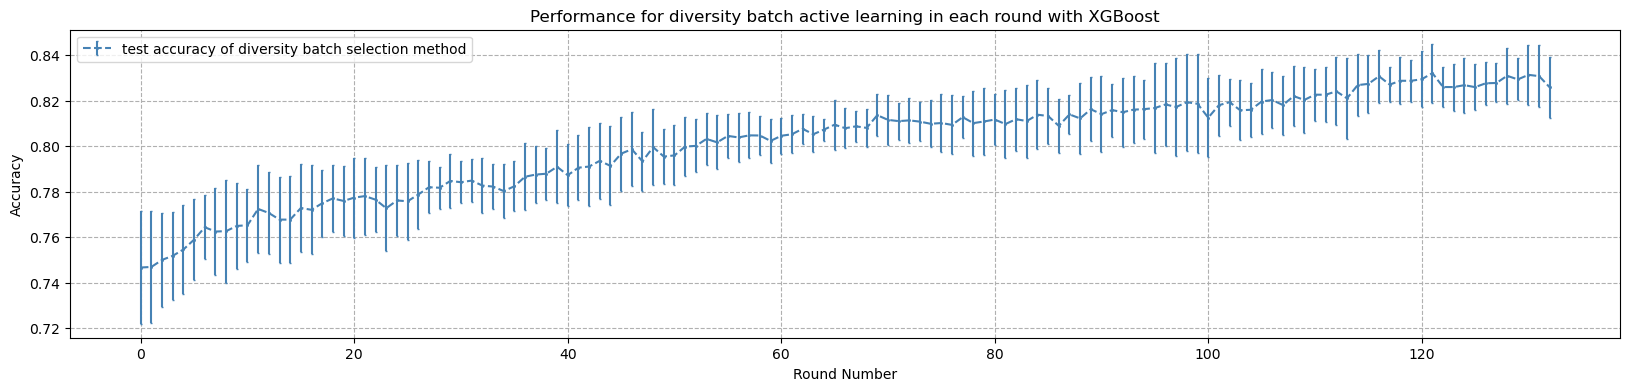

In [13]:
import matplotlib.pyplot as plt
test_mean_diversity_batch, test_std_diversity_batch = main()
print(test_mean_diversity_batch)
plt.figure(figsize=(20, 4))

plt.errorbar(np.arange(test_mean_diversity_batch.shape[0]),
             test_mean_diversity_batch,
             yerr=test_std_diversity_batch,
             fmt='s',
             color='steelblue',
             ecolor='steelblue',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='test accuracy of diversity batch selection method')

# to display the legend
plt.legend()

# set up the characteristics of the plot

plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.title('Performance for diversity batch active learning in each round with XGBoost')
plt.grid(True, linestyle='--')

# can save the fig to a folder
# plt.savefig('./imgs/e1_NB.png')
plt.show()


In [14]:
# store the results to avoid re-run
import pickle
with open('diversity_batch_results.pkl', 'wb') as f:
    pickle.dump([test_mean_diversity_batch, test_std_diversity_batch], f)


In [15]:
# example: load the results
# with open('diversity_batch_results.pkl', 'rb') as f:
#     test_mean_diversity_batch, test_std_diversity_batch = pickle.load(f)
#     print(test_mean_diversity_batch)

[0.74669699 0.74696181 0.75005436 0.75185185 0.75463873 0.75896763
 0.76440938 0.76251647 0.76270627 0.76499118 0.76529711 0.77246569
 0.77068086 0.76777778 0.76775774 0.77286925 0.77207691 0.7749776
 0.77710438 0.77597841 0.77743971 0.77811653 0.77653315 0.77278912
 0.77618723 0.77584244 0.77880447 0.78200732 0.78178694 0.78477961
 0.784219   0.78492393 0.78274428 0.78229167 0.78032939 0.78242678
 0.7866294  0.7875817  0.78795322 0.79102203 0.78729152 0.79060734
 0.79110639 0.79361702 0.79140014 0.79677113 0.7987152  0.79339533
 0.79964158 0.79549808 0.79601632 0.7999038  0.80019282 0.80326087
 0.80174292 0.80458515 0.80391442 0.80482456 0.8047619  0.80237396
 0.80463576 0.80530973 0.80771126 0.80530864 0.80734967 0.80952381
 0.80797912 0.80879422 0.80811486 0.81368869 0.81163782 0.81108597
 0.81141345 0.81085859 0.80992154 0.8102486  0.809433   0.81281855
 0.81021711 0.8109319  0.81177829 0.80979938 0.81193607 0.81111111
 0.81390831 0.81334372 0.80900338 0.81403234 0.81228758 0.81629

passive learning as a benchmark

In [16]:
import threading
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import xgboost as xgb

INIT_SIZE = int(0.1*(y.shape[0]))
BATCH_SIZE = 3

# Function to simulate a process that generates a float number based on a random seed
def process_passive(random_seed):
    np.random.seed(random_seed)
    idices = list(range(y.shape[0]))
    np.random.shuffle(idices)

    # initialize
    train_idices = idices[:INIT_SIZE]
    test_idices = idices[INIT_SIZE:]

    test_passive_per_seed = list()

    while (float(len(train_idices))/len(test_idices) < 0.5):

        clf = xgb.XGBClassifier(random_state=random_seed)
        clf.fit(X[train_idices], np.ravel(y[train_idices]))
        y_pred = clf.predict(X[test_idices])
        test_passive_per_seed.append(accuracy_score(np.ravel(y[test_idices]), y_pred))

        # select the next batch to mv from test to train
        # for passive learning, randomly select

        # for the batch, each from a different cluster
        for i in range(BATCH_SIZE):
            train_idices = idices[:len(train_idices)+1]
            test_idices = idices[len(train_idices):]

    return test_passive_per_seed

# Thread function to execute the process and append the result to a list
def thread_passive(seed, results, lock):
    result = process_passive(seed)
    with lock:
        results.append(result)

def main_passive():
    num_threads = 10
    test_passive_all = []
    threads = []
    lock = threading.Lock()

    # Create and start threads
    for i in range(num_threads):
        thread = threading.Thread(target=thread_passive, args=(i, test_passive_all, lock))
        threads.append(thread)
        thread.start()

    # Wait for all threads to complete
    for thread in threads:
        thread.join()

    # Calculate and print the mean of the results
    test_passive_all = np.array(test_passive_all)
    test_mean_passive_batch = np.mean(test_passive_all, axis=0)
    test_std_passive_batch = np.std(test_passive_all, axis=0)
    return test_mean_passive_batch, test_std_passive_batch



[0.74860299 0.75110677 0.75257665 0.75470588 0.75428946 0.75912073
 0.75542406 0.75869565 0.7570297  0.75562169 0.75619616 0.76049137
 0.76001331 0.76133333 0.76138945 0.76465863 0.76586184 0.77123656
 0.77239057 0.77422402 0.77342799 0.77350949 0.77569586 0.77768707
 0.77668712 0.78114754 0.77700205 0.78381344 0.78742268 0.78588154
 0.78799172 0.78755187 0.78995149 0.78972222 0.79053584 0.79072524
 0.79336129 0.7912465  0.79410526 0.79606188 0.79351656 0.79887006
 0.79964614 0.79978723 0.80028429 0.8011396  0.80078515 0.80414878
 0.80630824 0.80596264 0.80280778 0.80548341 0.80267534 0.80376812
 0.80624546 0.80691412 0.80547046 0.80804094 0.80747253 0.80800294
 0.81000736 0.80973451 0.81042129 0.81237037 0.81343727 0.81584821
 0.81469053 0.81487294 0.8188764  0.81561562 0.82091798 0.81930618
 0.82131519 0.82068182 0.82194381 0.82359209 0.82135774 0.82255352
 0.82398467 0.82580645 0.82625096 0.8283179  0.82923434 0.82891473
 0.82564103 0.82694704 0.82630757 0.82816901 0.82901961 0.8290

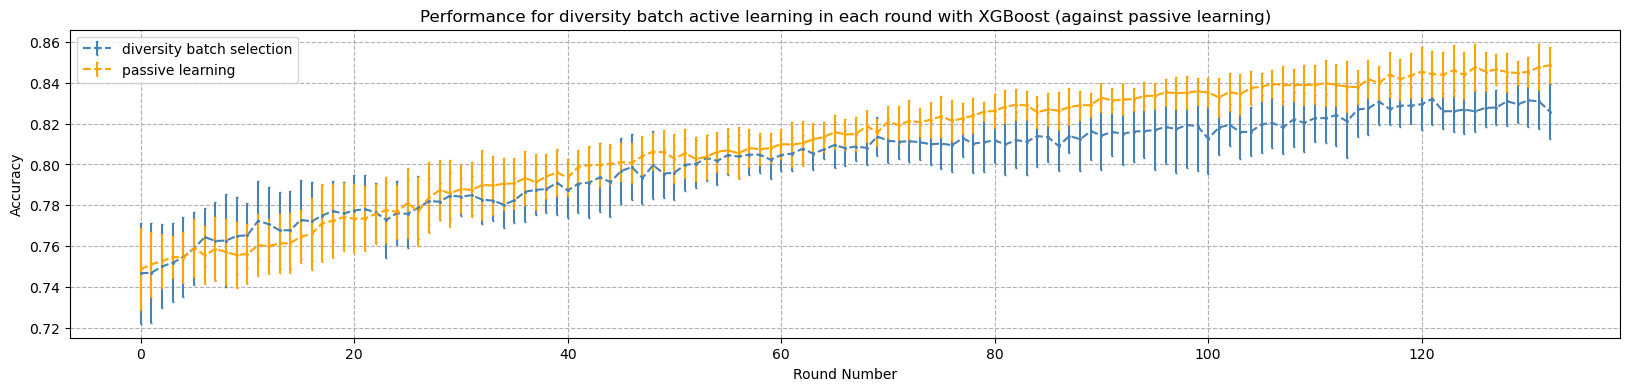

In [17]:
test_mean_passive_batch, test_std_passive_batch = main_passive()
print(test_mean_passive_batch)
plt.figure(figsize=(20, 4))

plt.errorbar(np.arange(test_mean_diversity_batch.shape[0]),
             test_mean_diversity_batch,
             yerr=test_std_diversity_batch,
             fmt='s',
             color='steelblue',
             ecolor='steelblue',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='diversity batch selection')

plt.errorbar(np.arange(test_mean_passive_batch.shape[0]),
             test_mean_passive_batch,
             yerr=test_std_passive_batch,
             fmt='s',
             color='orange',
             ecolor='orange',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='passive learning')

# to display the legend
plt.legend()

# set up the characteristics of the plot

plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.title('Performance for diversity batch active learning in each round with XGBoost (against passive learning)')
plt.grid(True, linestyle='--')

# can save the fig to a folder
# plt.savefig('./imgs/e1_NB.png')
plt.show()
